# Transformer Model for MIT data
As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling  
rescaling: MixMax Scaler

If you don't have the original files: run the notebook `preprocessing_mit_minmax_oversampling.ipynb`     
Input file:(The preprocessed data)     
mit_train_clean_mixmax_oversampling.csv
mit_test_clean_mixmax_oversampling.csv

Output: Transformer model trained  
model_mit_trans.h5

In [1]:
import sys
import os

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q
    !pip install tensorflow -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive.
    data_path = '/content/drive/MyDrive/data/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: c:\Users\igurs\Documents\GitHub\heartbeat-analysis-ai\notebooks


## Read data


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score


RawFiles = dict({
    'train': data_path + 'mitbih_train_clean_minmax_oversampling.csv',
    'test': data_path + 'mitbih_test_clean_minmax_oversampling.csv'
})


OutputFiles = dict({
    'model': model_output_path +  'model_mit_trans'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



# Transformer with MinMax Scaler and Oversampling

In [3]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Reshape the data to fit the LSTM model (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape of the data
print("X_train shape:", X_train.shape)  # samples, timesteps, features
print("X_test shape:", X_test.shape)    # samples, timesteps, features



X_train shape: (144942, 187, 1)
X_test shape: (20284, 187, 1)


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Dropout, Add, LayerNormalization, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Set random seed for reproducibility
tf.random.set_seed(42)

# Optimized Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.4, l2_reg=1e-5):  # Increased dropout to 0.4
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    x_ff = Dense(ff_dim, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1], kernel_regularizer=l2(l2_reg))(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# Input Layer
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Stacked Transformer Encoder Layers
for _ in range(4):  # Stack the encoder block 4 times
    x = transformer_encoder(inputs if _ == 0 else x, head_size=64, num_heads=8, ff_dim=256, dropout=0.2, l2_reg=1e-5)

# Global Pooling and Dense Layers for Classification
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(1e-5))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

# Define Model
model = Model(inputs, outputs)

# Optimizer
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate for stable training

# Compile Model
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name='auc')])

# Model Summary
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Testing/Evaluation on Test Set
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

# Generate Predictions and Classification Report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 187, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 187, 1)         │          3,585 │ input_layer_1[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 187, 1)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 187, 1)         │              0 │ dropout_15[0][0],      │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 187, 1)         │              2 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 187, 256)       │            512 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 187, 256)       │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 187, 1)         │            257 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 187, 1)         │              0 │ layer_normalization_8… │
│                           │                        │                │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 187, 1)         │              2 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 187, 1)         │          3,585 │ layer_normalization_9… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 187, 1)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 187, 1)         │              0 │ dropout_18[0][0],      │
│                           │                        │                │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 187, 1)         │              2 │ add_10[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 187, 256)       │            512 │ layer_normalization_1… │
├──────────────────────

 Total params: 18,201 (71.10 KB)

 Trainable params: 18,201 (71.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 178s 32ms/step - accuracy: 0.4957 - auc: 0.5000 - loss: 0.6932 - val_accuracy: 0.8932 - val_auc: 0.5000 - val_loss: 0.6927 - learning_rate: 1.0000e-04
Epoch 2/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 170s 28ms/step - accuracy: 0.4971 - auc: 0.5000 - loss: 0.6932 - val_accuracy: 0.8932 - val_auc: 0.5000 - val_loss: 0.6926 - learning_rate: 1.0000e-04
Epoch 3/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - accuracy: 0.4979 - auc: 0.5000 - loss: 0.6932 - val_accuracy: 0.8932 - val_auc: 0.5000 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 4/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 147s 29ms/step - accuracy: 0.4983 - auc: 0.5000 - loss: 0.6932 - val_accuracy: 0.8932 - val_auc: 0.5000 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 5/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 144s 29ms/step - accuracy: 0.4982 - auc: 0.5000 - loss: 0.6932 - val_accuracy: 0.8932 - val_auc: 0.5000 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 6/100
4530/4530 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Extract the training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

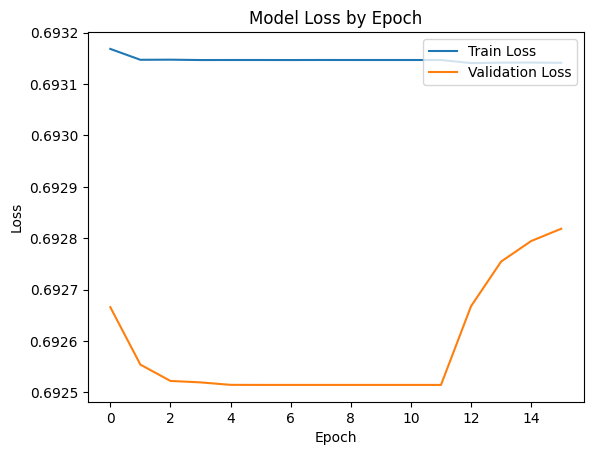

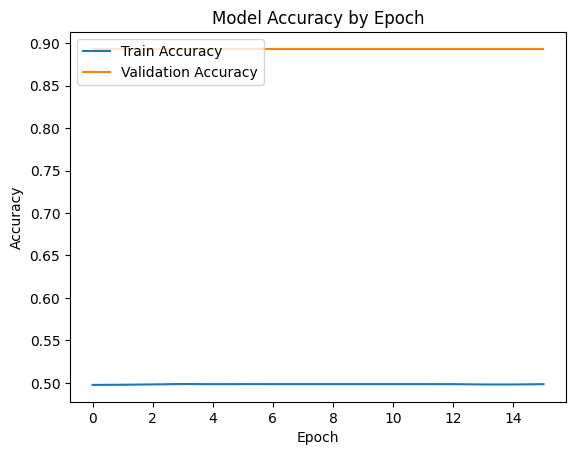

In [9]:
import matplotlib.pyplot as plt

# Plotting the Loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Save model

In [11]:
# Save the model with TensorFlow format
model_path = OutputFiles.get('model') + '.h5'  # Append .h5 extension
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/data/model_mit_trans.h5


In [10]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-11-14 17:04:22.505222
